In [1]:
options(warn = -1)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(dplyr))

In [2]:
min_cells = 10

In [3]:
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')

files = list('B_naive'='h5ad/df.fil3_gex_bcells_vdj_sce_B_naive_230622.RDS',
             'B_non-switched_mem'='h5ad/df.fil3_gex_bcells_vdj_sce_B_nonswitched_mem_230622.RDS',
             'B_switched_mem'='h5ad/df.fil3_gex_bcells_vdj_sce_B_switched_mem_230622.RDS',
             'B_ASC'='h5ad/df.fil3_gex_bcells_vdj_sce_B_ASC_all_230622.RDS'
            )
prep_data <- function(sce){
    counts(sce) <- assays(sce)[['X']] # because i'm saving from a h5ad object with anndata2ri
    sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
    sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
    sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
    sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
    sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
    sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
    sce$age_scaled <- scale(sce$calc_age) # scale age
    # remove samples >21 days
    sce2 <- sce[,sce$time_from_infection <= 21] # prevent issues with spline
    # Remove samples with less than 10 cells
    nCells <- table(sce2$sample_id)
    rmSamples <- names(nCells[nCells < min_cells])
    sce2 <- sce2[, !sce2$sample_id %in% rmSamples]
    # remove negatives and recoveries
    sce3 <- sce2[,sce2$case_control == 'POSITIVE']
    return(sce3)
}

In [4]:
summarise_info <- function(sce){
    # Summarize Counts
    smrzd <- aggregateAcrossCells(sce, id = as.character(colData(sce)[, c("sample_id")]))
    smrzd <- logNormCounts(smrzd)
    # add vaccination info
    vacc <- read.csv('vaccination.csv')
    # all wave 1 are unvaccinated
    smrzd$vaccine <- FALSE
    smrzd$vaccine[smrzd$centre == 'Cambridge'] <- NA
    smrzd$vaccine <- vacc$vaccine[match(smrzd$individual_id, vacc$individual_id)]
    # adjust the individuals that are found in both waves
    smrzd$vaccine[smrzd$individual_id %in% c('C101', 'C108', 'C137', 'C138', 'C140', 'C141', 'C145', 'C146', 'C147', 'C168', 'C169', 'C170', 'C187', 'C190', 'C33') & smrzd$centre == 'NCL'] <- FALSE
    smrzd$vaccine[smrzd$centre == 'NCL'] <- FALSE
    return(smrzd)
}

In [5]:
# Read in files
sces <- lapply(files, readRDS)

In [6]:
# prep files
sces <- lapply(sces, prep_data)

In [7]:
# Summarize Counts
smrzds <- lapply(sces, summarise_info)

### Split

In [8]:
## subset to waves
subset_wave <- function(smrzd, wave){
    return(smrzd[,smrzd$centre == wave])
}

In [9]:
wave1 <- lapply(smrzds, subset_wave, 'NCL')
wave2 <- lapply(smrzds, subset_wave, 'Cambridge')

In [10]:
fullFormula1 = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + (1|individual_id)")
fullFormula1

geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + 
    sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + 
    (1 | individual_id)

### Run the spline model but on gene sets

### Hallmark

In [11]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [12]:
df_res1 <- list()
fits1 <- list()
for (i in seq_along(wave1)){
    seu <- as.Seurat(wave1[[i]])
    data <- seu@meta.data
    seu <- AddModuleScore(seu, features = genelists, name = names(genelists))
    fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
        data$geneset <- seu@meta.data[,x]
        fit <- suppressMessages(lmerTest::lmer(fullFormula1, data = data))
        return(list(fit=fit, data=data))
    })
    fit_res <- lapply(fits, function(x) anova(x$fit))
    singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
    conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
    pvals <- lapply(fit_res, function(x) x[7,6])
    fdrvals <- p.adjust(pvals, method = 'BH')
    df_res1[[names(wave1)[i]]] <- data.frame(
        pvals = unlist(pvals), 
        fdrvals = unlist(fdrvals), 
        singular = unlist(singular),
        conv = unlist(conv), 
        row.names = paste0(names(genelists), 1:length(genelists)))
    fits1[[names(wave1)[i]]] <- fits
}

In [13]:
df_res2 <- list()
fits2 <- list()
for (i in seq_along(wave2)){
    seu <- as.Seurat(wave2[[i]])
    data <- seu@meta.data
    seu <- AddModuleScore(seu, features = genelists, name = names(genelists))
    fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
        data$geneset <- seu@meta.data[,x]
        fit <- suppressMessages(lmerTest::lmer(fullFormula1, data = data))
        return(list(fit=fit, data=data))
    })
    fit_res <- lapply(fits, function(x) anova(x$fit))
    singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
    conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
    pvals <- lapply(fit_res, function(x) x[7,6])
    fdrvals <- p.adjust(pvals, method = 'BH')
    df_res2[[names(wave2)[i]]] <- data.frame(
        pvals = unlist(pvals), 
        fdrvals = unlist(fdrvals), 
        singular = unlist(singular),
        conv = unlist(conv), 
        row.names = paste0(names(genelists), 1:length(genelists)))
    fits2[[names(wave2)[i]]] <- fits
}

In [14]:
lapply(df_res1, function(x) x[x$pvals < 0.05 & x$conv == 0,])

,pvals,fdrvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_COMPLEMENT11,0.035639124,0.2545652,0,0
HALLMARK_ESTROGEN_RESPONSE_EARLY15,0.009972549,0.2231616,0,0
HALLMARK_ESTROGEN_RESPONSE_LATE16,0.042784123,0.2674008,0,0
HALLMARK_IL2_STAT5_SIGNALING23,0.023227029,0.2440969,0,0
HALLMARK_INFLAMMATORY_RESPONSE25,0.011389506,0.2231616,0,0
HALLMARK_MYC_TARGETS_V233,0.029136222,0.2440969,0,0
HALLMARK_TNFA_SIGNALING_VIA_NFKB45,0.013389697,0.2231616,0,0
,pvals,fdrvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>


In [15]:
lapply(df_res2, function(x) x[x$pvals < 0.05 & x$conv == 0,])

,pvals,fdrvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_INTERFERON_ALPHA_RESPONSE26,0.014678285,0.1834786,0,0
HALLMARK_INTERFERON_GAMMA_RESPONSE27,0.007051483,0.1762871,0,0
HALLMARK_SPERMATOGENESIS43,0.047166644,0.3369046,0,0
HALLMARK_UNFOLDED_PROTEIN_RESPONSE46,0.003808062,0.1762871,0,0
,pvals,fdrvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_GLYCOLYSIS19,0.0406636993,0.314656005,0,0
HALLMARK_HEME_METABOLISM21,0.0440518407,0.314656005,0,0
HALLMARK_IL2_STAT5_SIGNALING23,0.0398098962,0.314656005,0,0


### Combined

In [16]:
fullFormula2 = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + centre + (1|individual_id)")
fullFormula2

geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + 
    sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + 
    centre + (1 | individual_id)

In [17]:
df_res3 <- list()
fits3 <- list()
for (i in seq_along(smrzds)){
    seu <- as.Seurat(smrzds[[i]])
    data <- seu@meta.data
    seu <- AddModuleScore(seu, features = genelists, name = names(genelists))
    fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
        data$geneset <- seu@meta.data[,x]
        fit <- suppressMessages(lmerTest::lmer(fullFormula2, data = data))
        return(list(fit=fit, data=data))
    })
    fit_res <- lapply(fits, function(x) anova(x$fit))
    singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
    conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
    pvals <- lapply(fit_res, function(x) x[8,6])
    fdrvals <- p.adjust(pvals, method = 'BH')
    df_res3[[names(smrzds)[i]]] <- data.frame(
        pvals = unlist(pvals), 
        fdrvals = unlist(fdrvals), 
        singular = unlist(singular),
        conv = unlist(conv), 
        row.names = paste0(names(genelists), 1:length(genelists)))
    fits3[[names(smrzds)[i]]] <- fits
}

In [18]:
out <- lapply(df_res3, function(x) x[x$pvals < 0.05 & x$conv == 0,])
out

,pvals,fdrvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_INFLAMMATORY_RESPONSE25,0.039437002,0.2663681,0,0
HALLMARK_INTERFERON_ALPHA_RESPONSE26,0.017591804,0.2663681,0,0
HALLMARK_INTERFERON_GAMMA_RESPONSE27,0.002070627,0.1035314,0,0
HALLMARK_KRAS_SIGNALING_UP29,0.042618891,0.2663681,0,0
HALLMARK_MYC_TARGETS_V233,0.041107804,0.2663681,0,0
,pvals,fdrvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_ESTROGEN_RESPONSE_EARLY15,1.369599e-02,0.2057804139,0,0
HALLMARK_INFLAMMATORY_RESPONSE25,1.646243e-02,0.2057804139,0,0


In [21]:
df <- do.call(rbind, out)
write.csv(df, 'gsea_results.csv')

In [19]:
theme_set(theme_pubr())

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



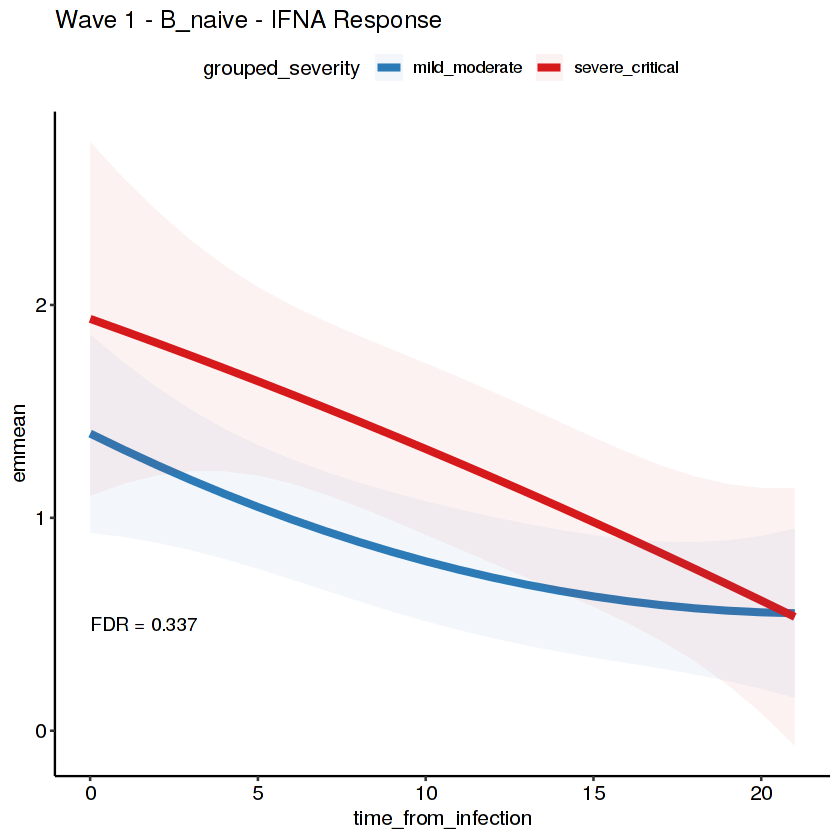

Saving 6.67 x 6.67 in image



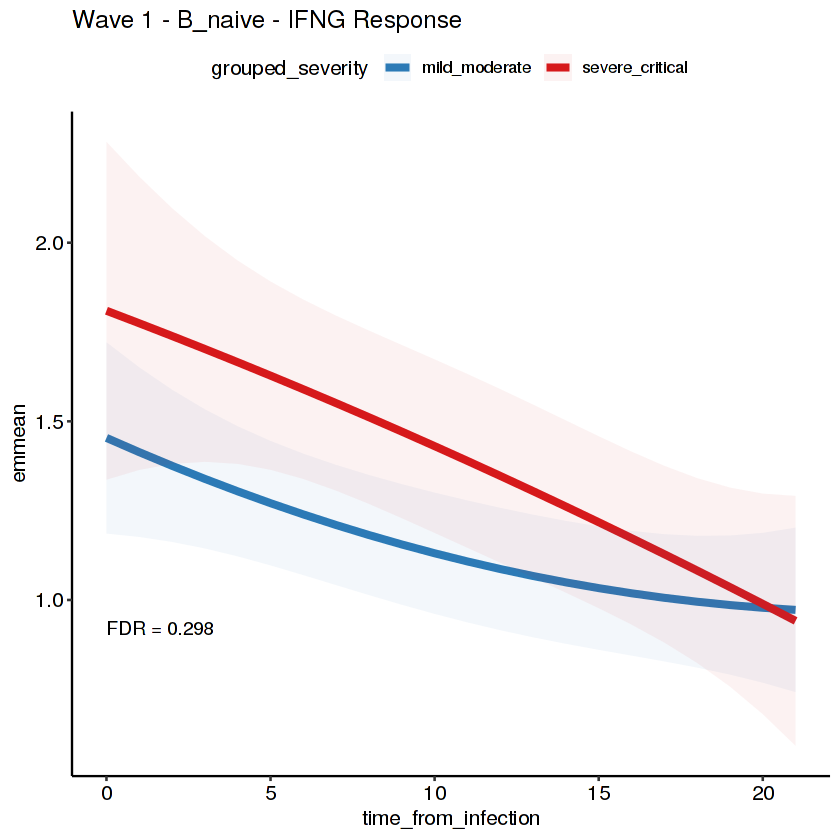

Saving 6.67 x 6.67 in image



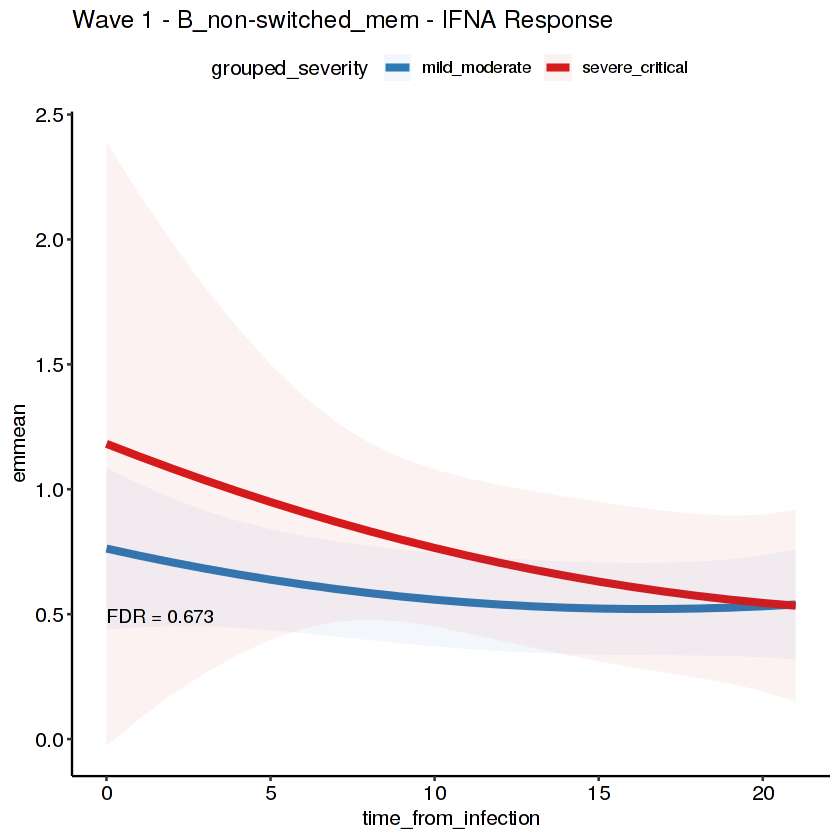

Saving 6.67 x 6.67 in image



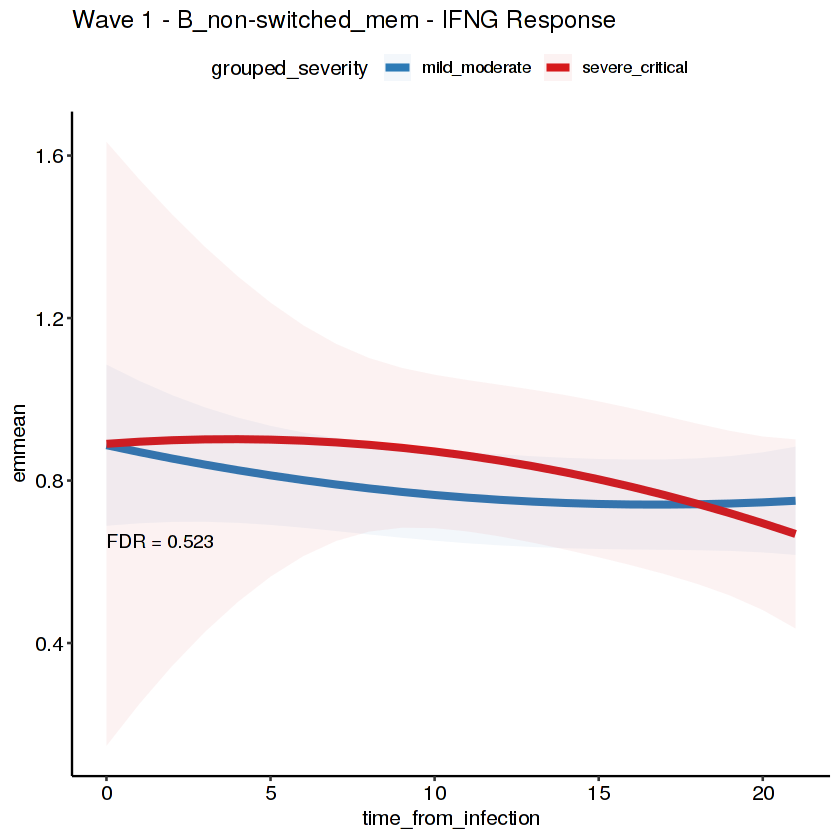

Saving 6.67 x 6.67 in image



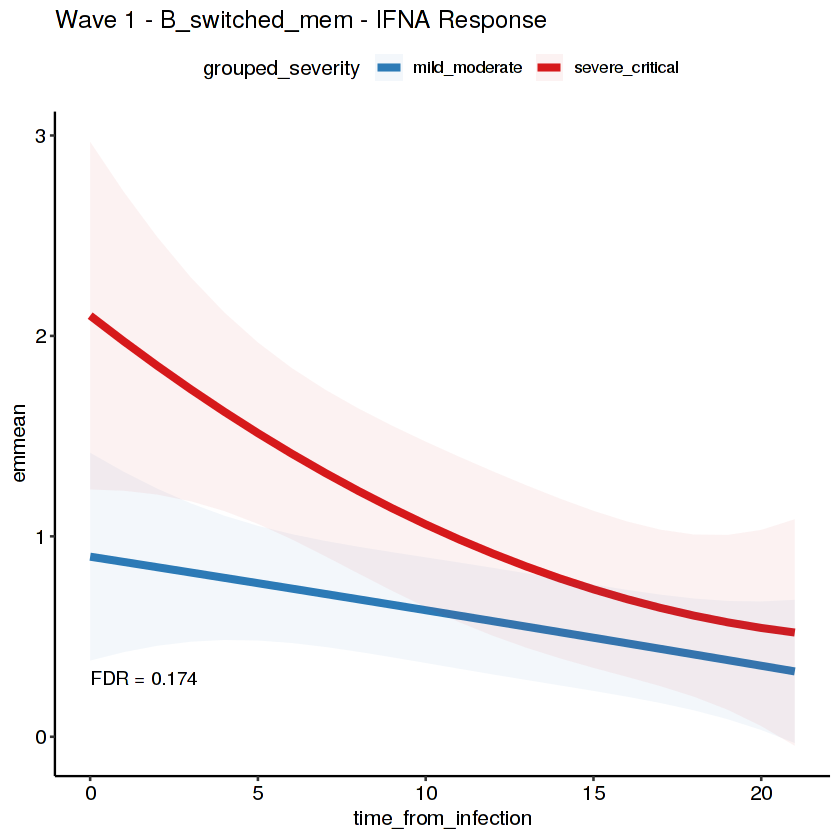

Saving 6.67 x 6.67 in image



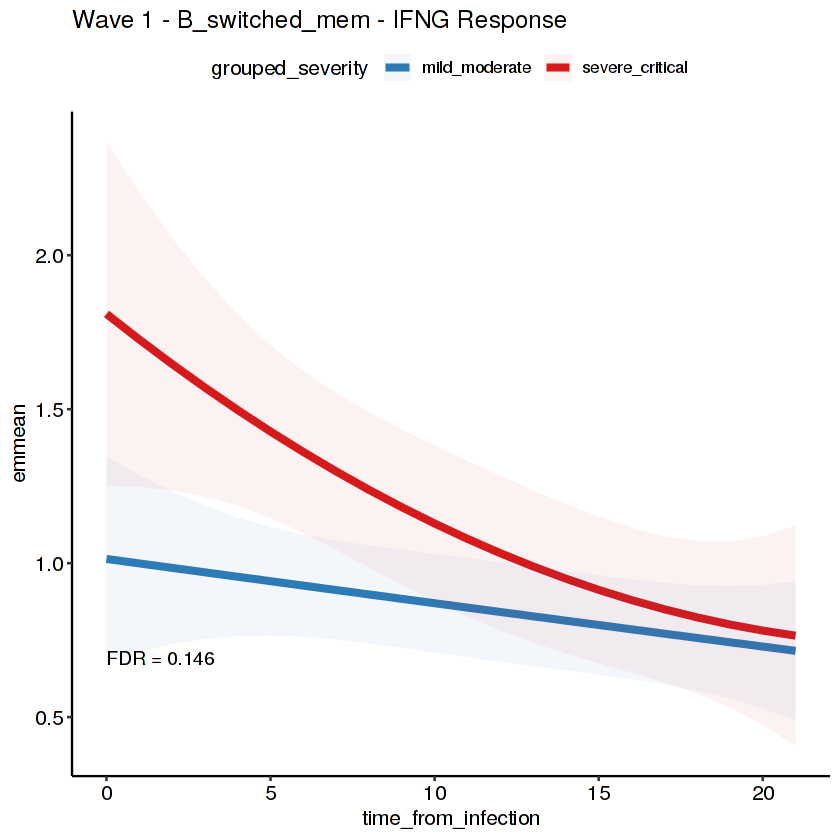

Saving 6.67 x 6.67 in image



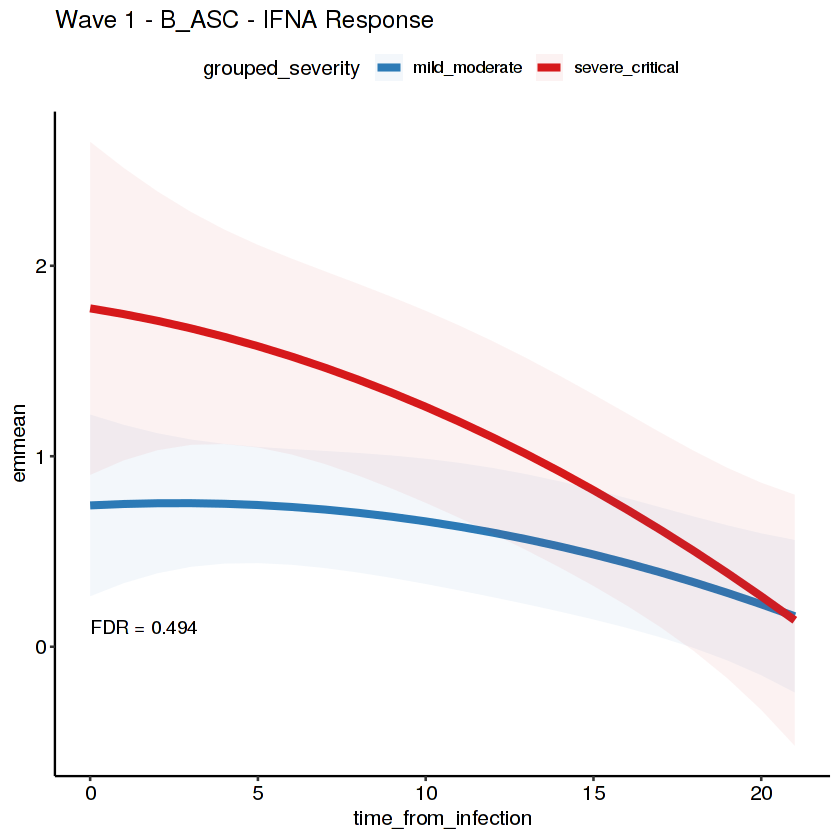

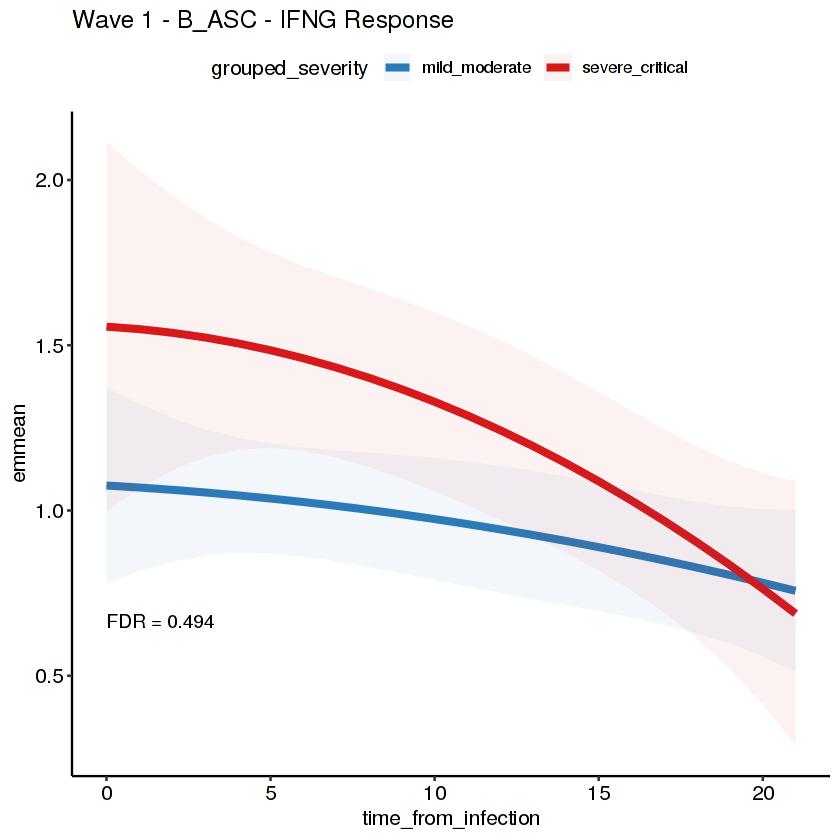

In [63]:
for (i in seq_along(fits1)){
    for (j in c(26, 27)){
        x = emmeans(fits1[[i]][[j]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
        if (j == 26){
            jj = 'IFNA Response'
        } else {
            jj = 'IFNG Response'
        }
        main = paste0('Wave 1 - ', names(fits1)[i], ' - ', jj)
        p <- ggplot(data.frame(x), 
                    aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
        geom_line(aes(colour = grouped_severity), size = 1.7) +
        geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
        scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
        scale_fill_manual(values = c("#2C7BB6", "#D7191C")) +
        ggtitle(main) +
        annotate(geom = 'text', label = paste0('FDR = ', signif(df_res1[[i]][j,2], digits = 3)), x = 0, y = min(data.frame(x)$emmean), hjust = 0, vjust = 1)
        print(p)
        ggsave(paste0('figures/longitudinal_geneset/', main, '.pdf'), plot = p)
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



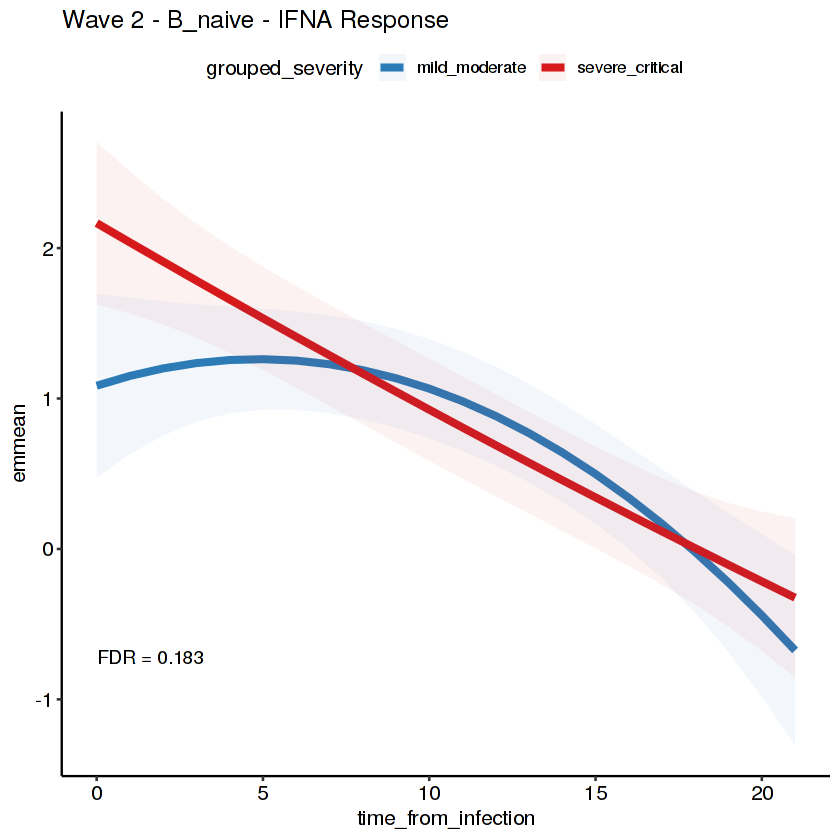

Saving 6.67 x 6.67 in image



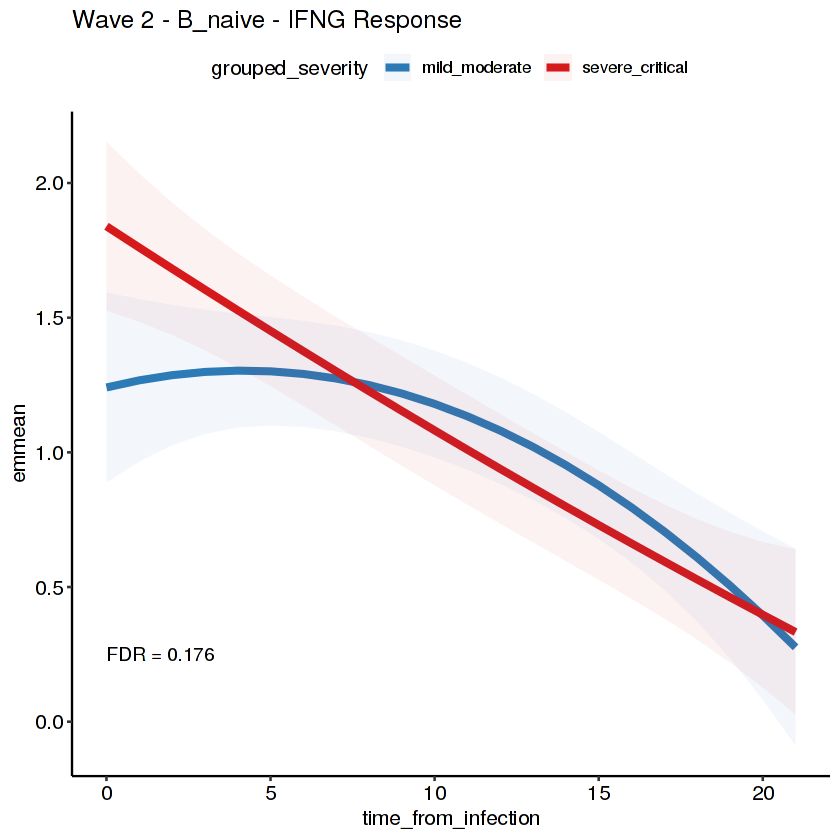

Saving 6.67 x 6.67 in image



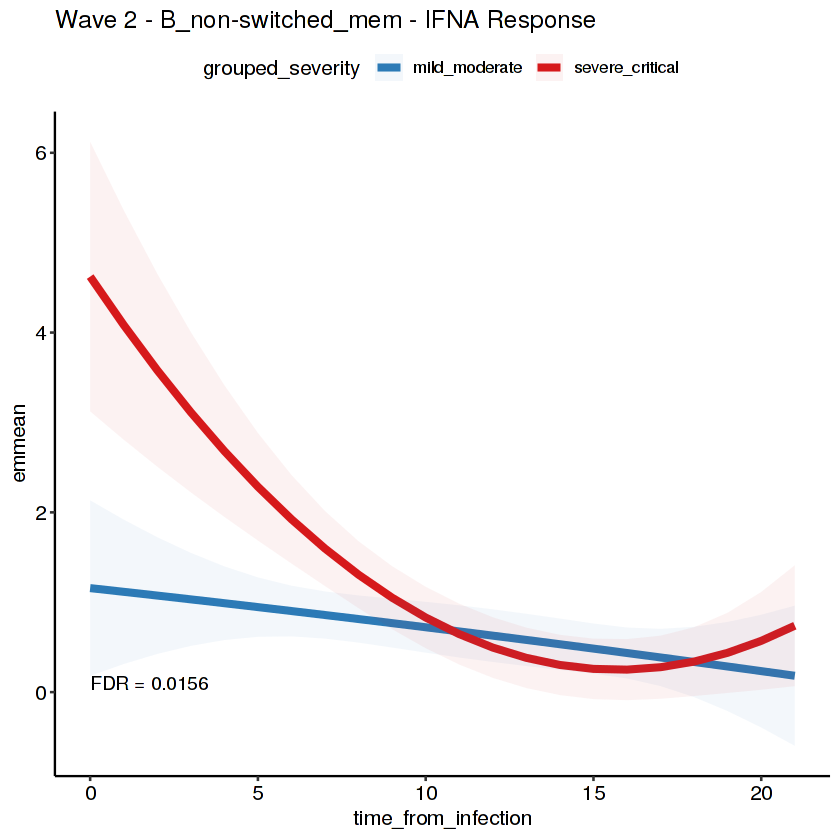

Saving 6.67 x 6.67 in image



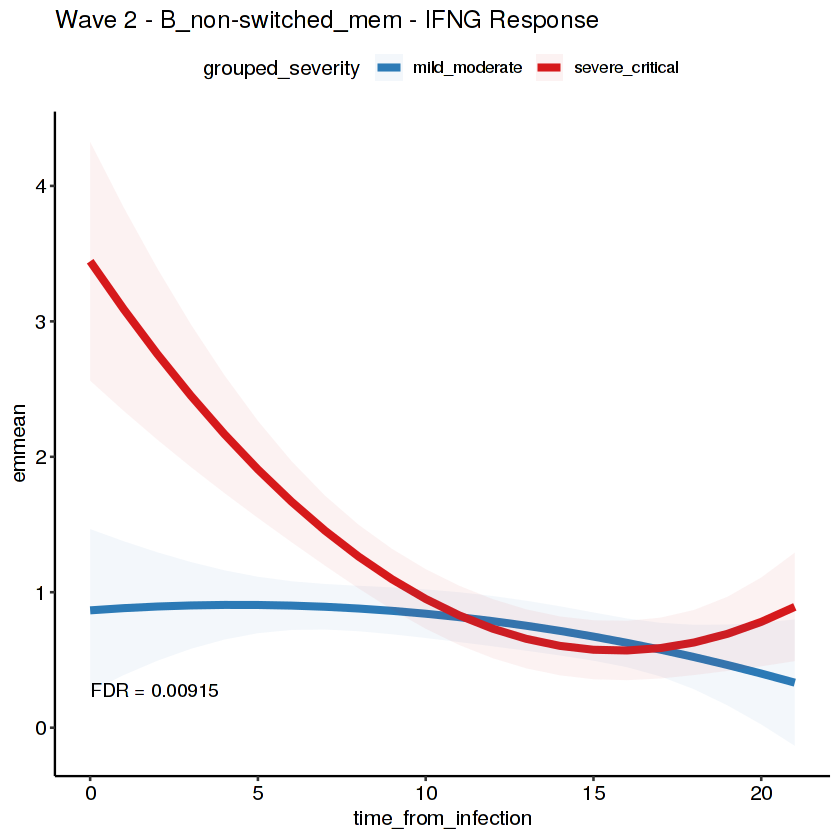

Saving 6.67 x 6.67 in image



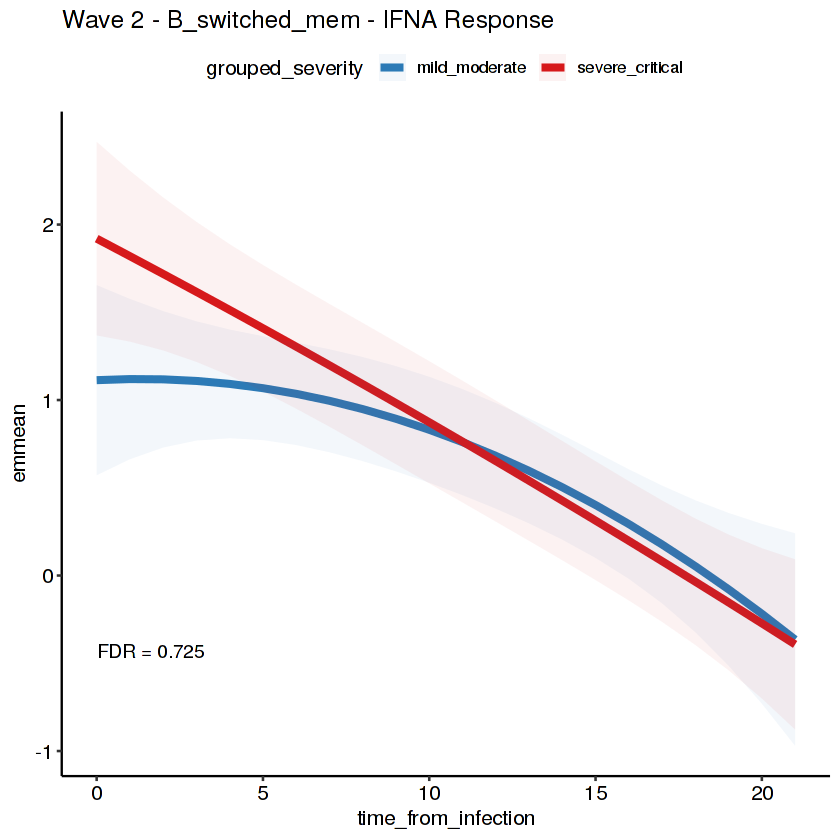

Saving 6.67 x 6.67 in image



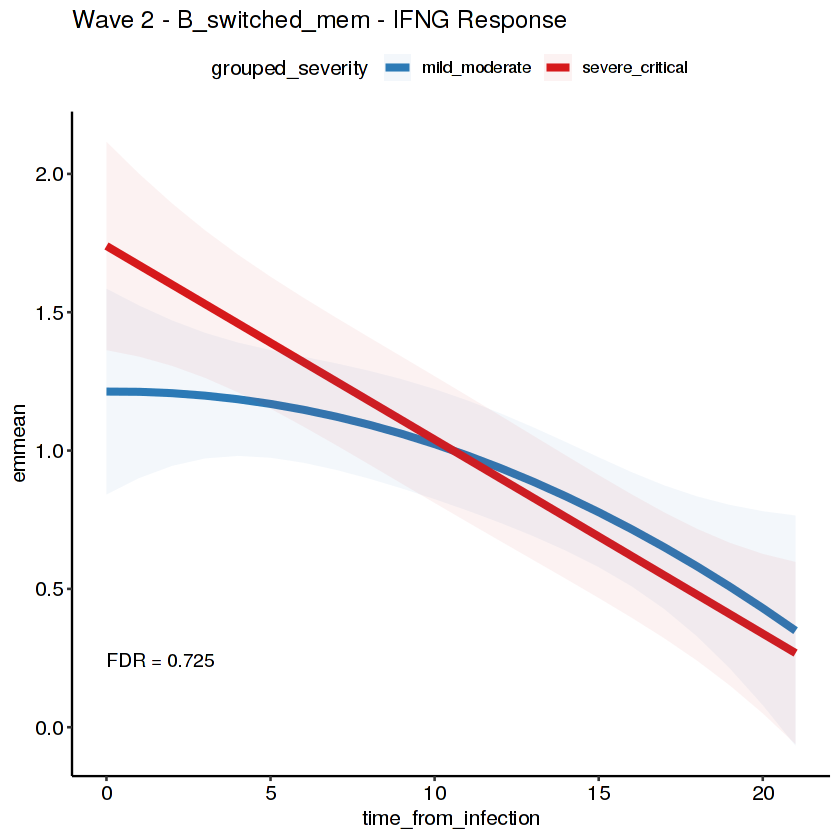

Saving 6.67 x 6.67 in image



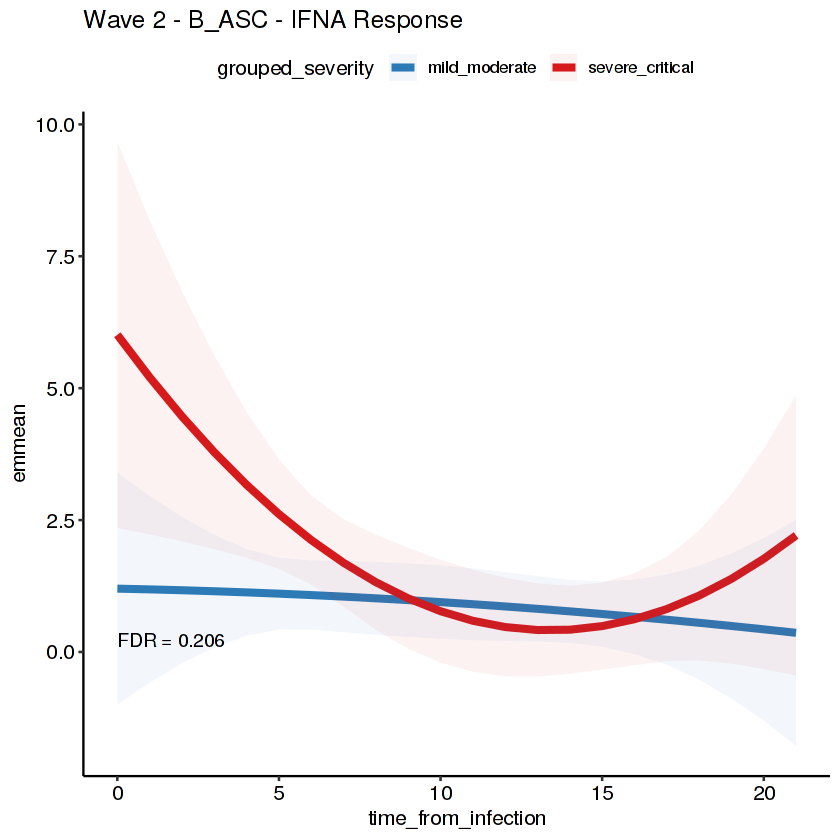

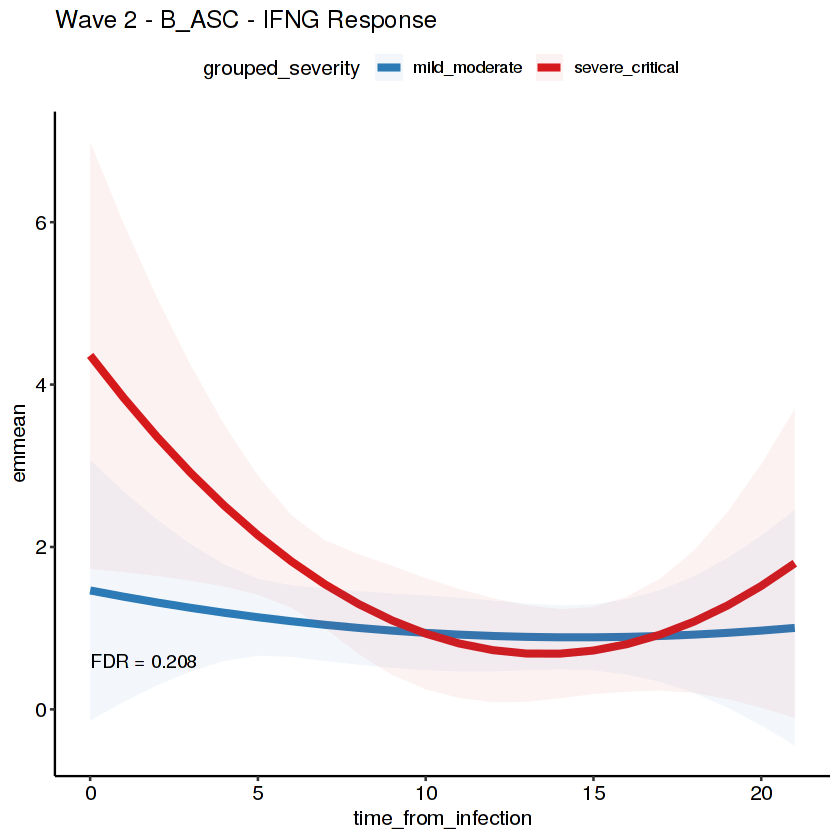

In [64]:
for (i in seq_along(fits2)){
    for (j in c(26, 27)){
        x = emmeans(fits2[[i]][[j]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
        if (j == 26){
            jj = 'IFNA Response'
        } else {
            jj = 'IFNG Response'
        }
        main = paste0('Wave 2 - ', names(fits2)[i], ' - ', jj)
        p <- ggplot(data.frame(x), 
                    aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
        geom_line(aes(colour = grouped_severity), size = 1.7) +
        geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
        scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
        scale_fill_manual(values = c("#2C7BB6", "#D7191C")) +
        ggtitle(main) +
        annotate(geom = 'text', label = paste0('FDR = ', signif(df_res2[[i]][j,2], digits = 3)), x = 0, y = min(data.frame(x)$emmean), hjust = 0, vjust = 1)
        print(p)
        ggsave(paste0('figures/longitudinal_geneset/', main, '.pdf'), plot = p)
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



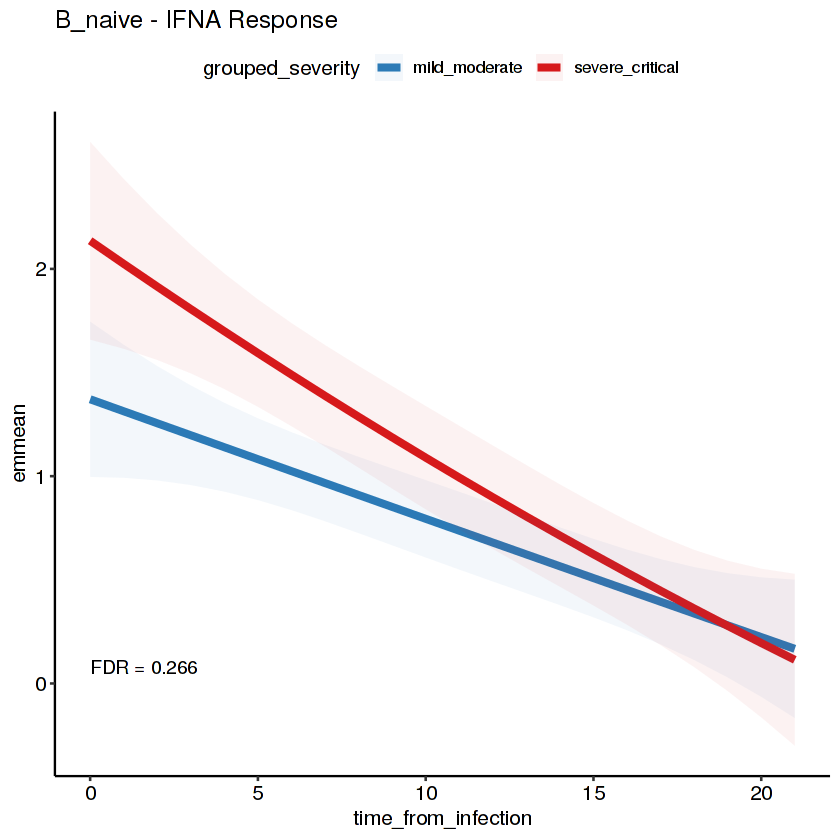

Saving 6.67 x 6.67 in image



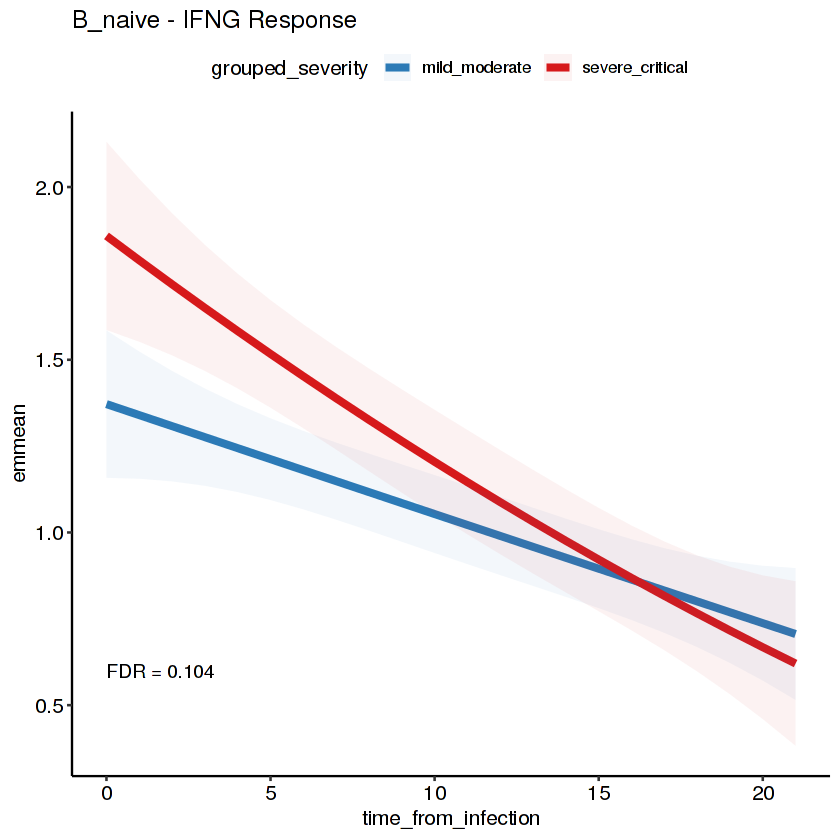

Saving 6.67 x 6.67 in image



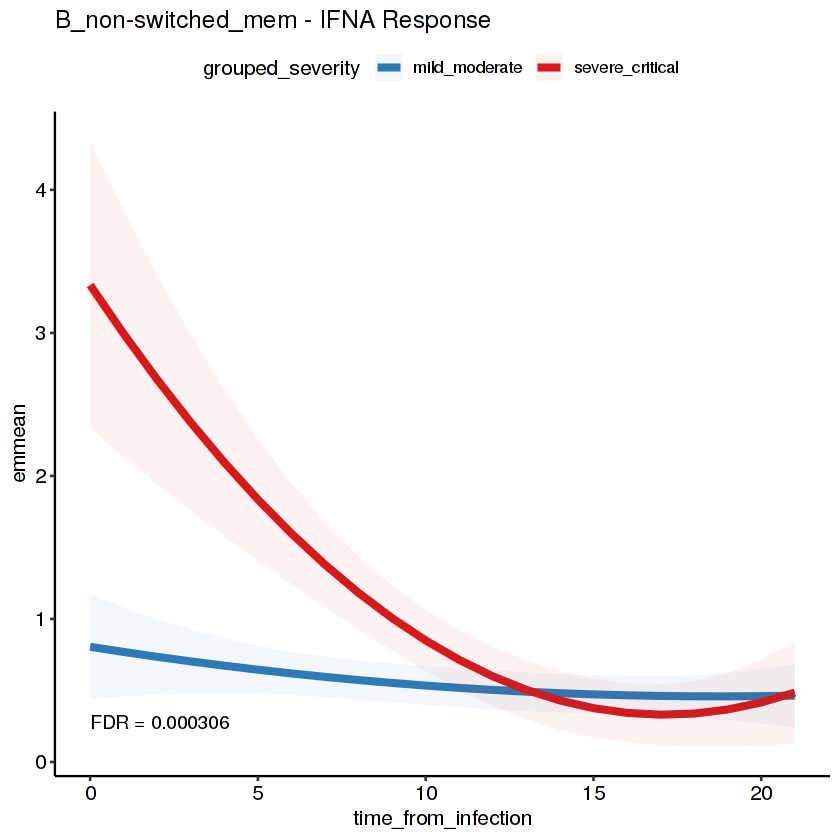

Saving 6.67 x 6.67 in image



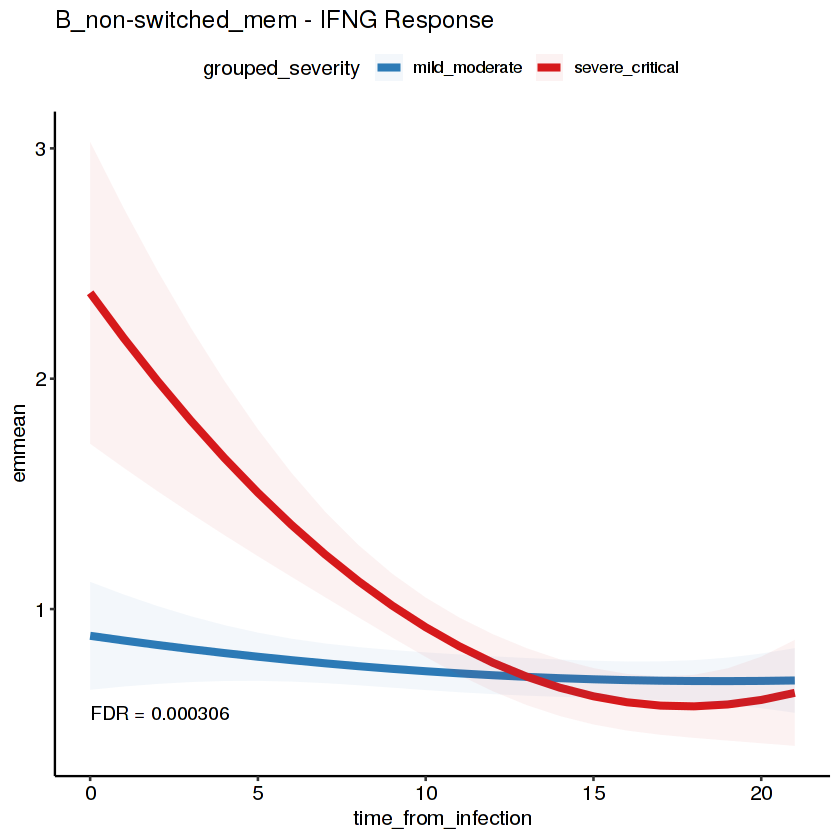

Saving 6.67 x 6.67 in image



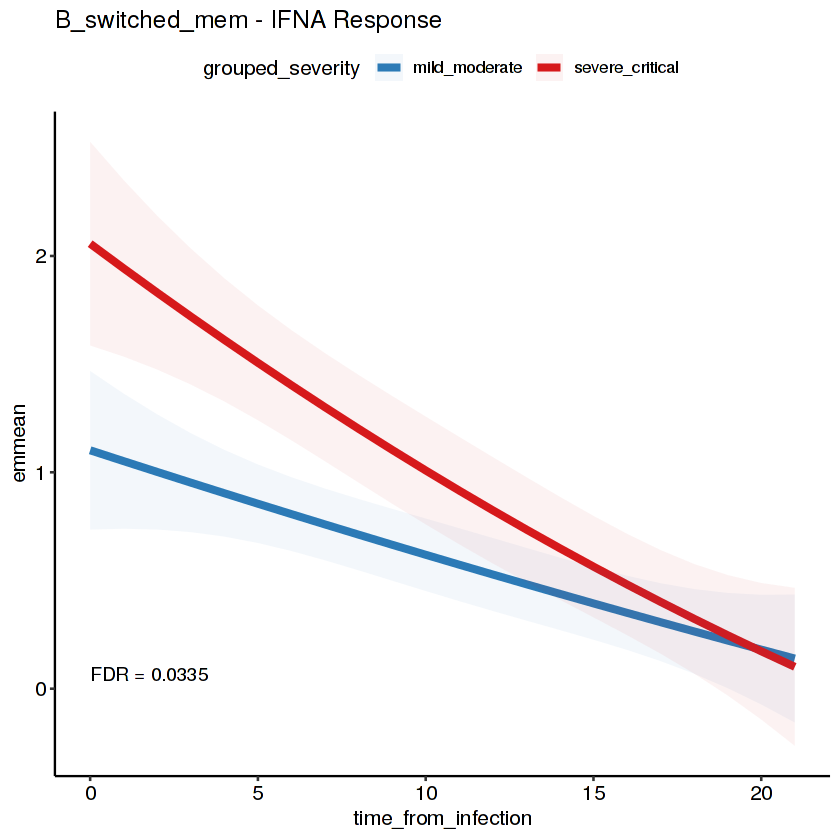

Saving 6.67 x 6.67 in image



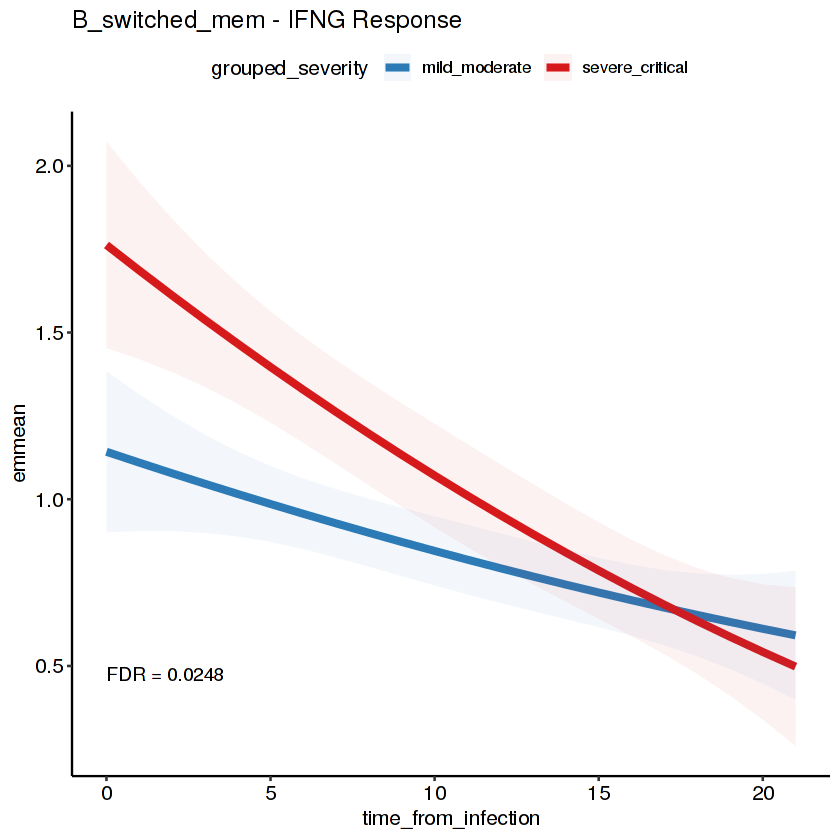

Saving 6.67 x 6.67 in image



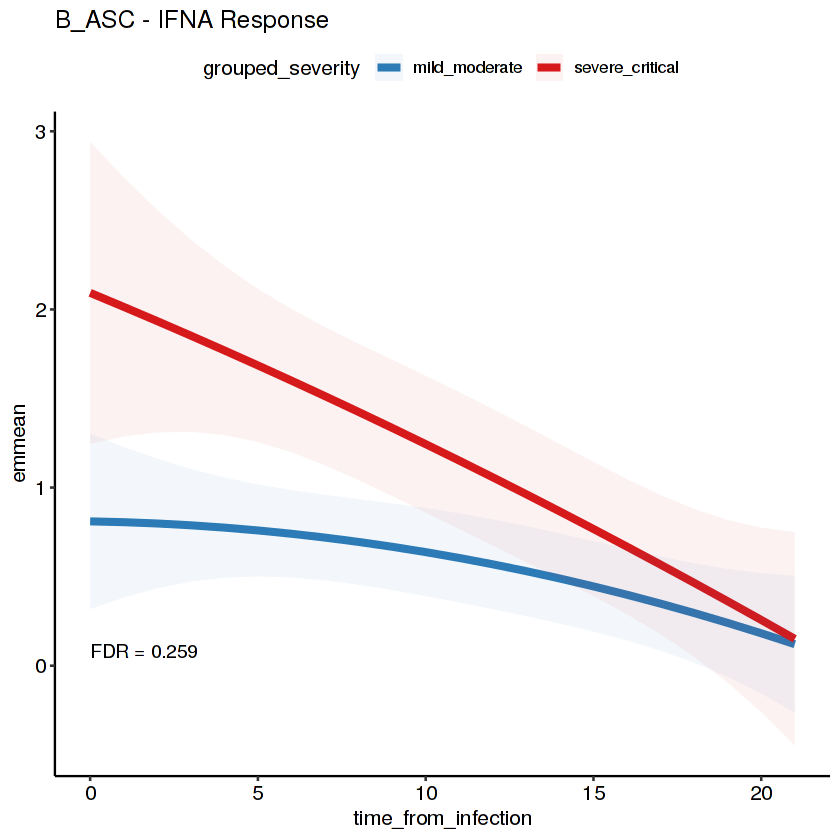

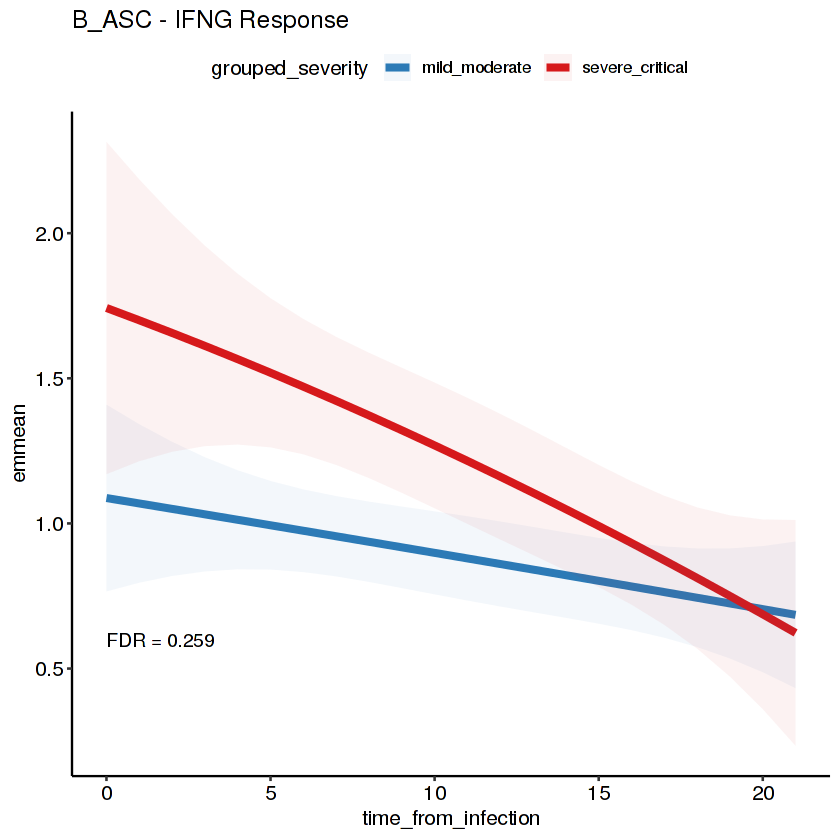

In [65]:
for (i in seq_along(fits3)){
    for (j in c(26, 27)){
        x = emmeans(fits3[[i]][[j]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
        if (j == 26){
            jj = 'IFNA Response'
        } else {
            jj = 'IFNG Response'
        }
        main = paste0(names(fits3)[i], ' - ', jj)
        p <- ggplot(data.frame(x), 
                    aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
        geom_line(aes(colour = grouped_severity), size = 1.7) +
        geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
        scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
        scale_fill_manual(values = c("#2C7BB6", "#D7191C")) +
        ggtitle(main) +
        annotate(geom = 'text', label = paste0('FDR = ', signif(df_res3[[i]][j,2], digits = 3)), x = 0, y = min(data.frame(x)$emmean), hjust = 0, vjust = 1)
        print(p)
        ggsave(paste0('figures/longitudinal_geneset/', main, '.pdf'), plot = p)
    }
}

In [66]:
# ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~grouped_severity) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~grouped_severity) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

### add vaccination as an interaction but for wave2 only

In [20]:
fullFormulav = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * vaccine + sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + (1|individual_id)")
fullFormulav

geneset ~ splines::bs(time_from_infection, degree = 2) * vaccine + 
    sex + PC1_nonafricanVsAfrican + PC2_asianVsEuropean + age_scaled + 
    (1 | individual_id)

In [34]:
df_res2v <- list()
fits2v <- list()
for (i in seq_along(wave2)){
    seu <- as.Seurat(wave2[[i]])
    data <- seu@meta.data
    seu <- AddModuleScore(seu, features = genelists, name = names(genelists))
    fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
        data$geneset <- seu@meta.data[,x]
        fit <- suppressMessages(lmerTest::lmer(fullFormulav, data = data))
        return(list(fit=fit, data=data))
    })
    fit_res <- lapply(fits, function(x) anova(x$fit))
    singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
    conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
    pvals <- lapply(fit_res, function(x) x[7,6])
    fdrvals <- p.adjust(pvals, method = 'BH')
    df_res2v[[names(wave2)[i]]] <- data.frame(
        pvals = unlist(pvals), 
        fdrvals = unlist(fdrvals), 
        singular = unlist(singular),
        conv = unlist(conv), 
        row.names = paste0(names(genelists), 1:length(genelists)))
    fits2v[[names(wave2)[i]]] <- fits
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



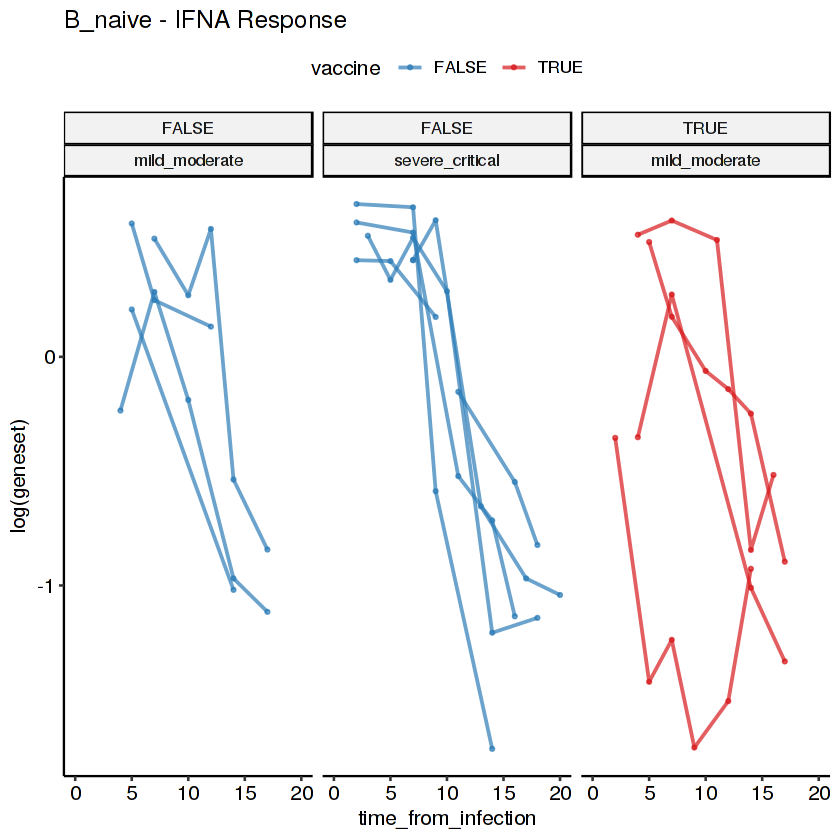

Saving 6.67 x 6.67 in image



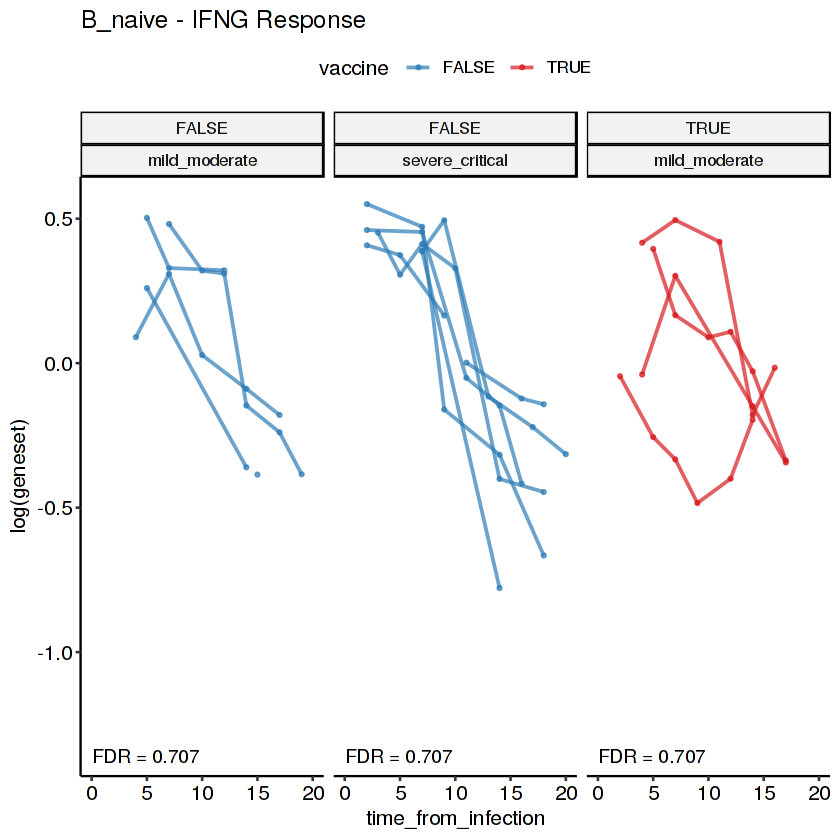

Saving 6.67 x 6.67 in image



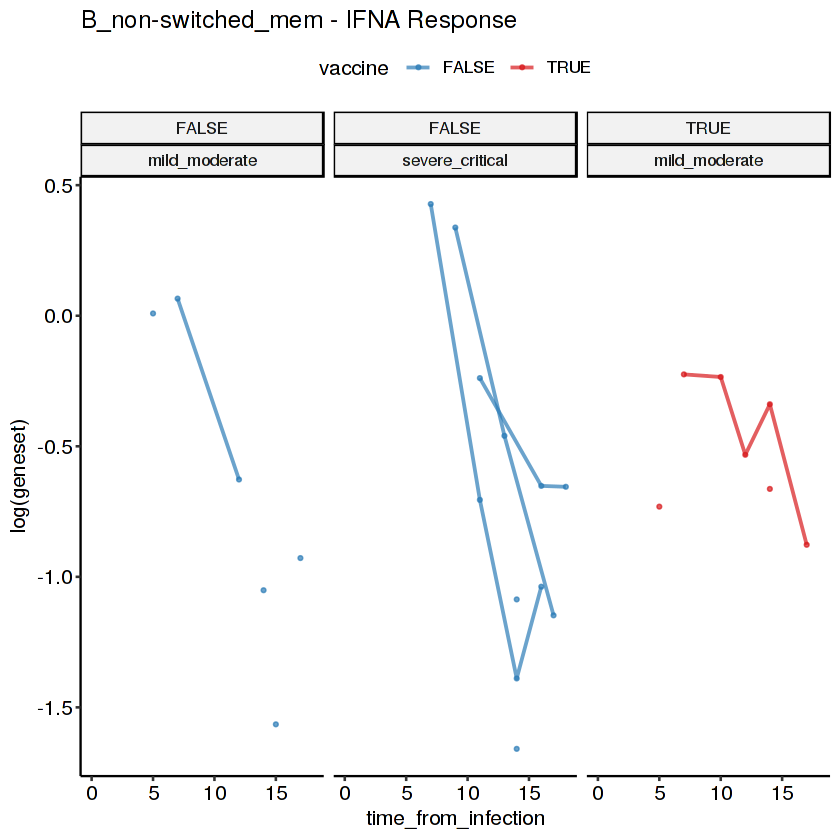

Saving 6.67 x 6.67 in image



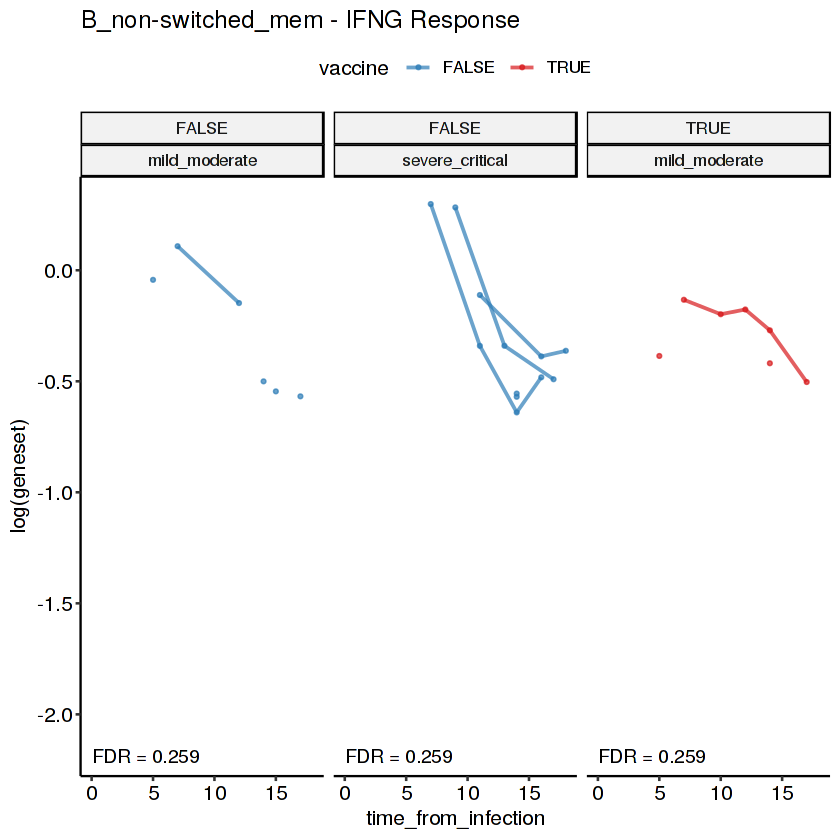

Saving 6.67 x 6.67 in image



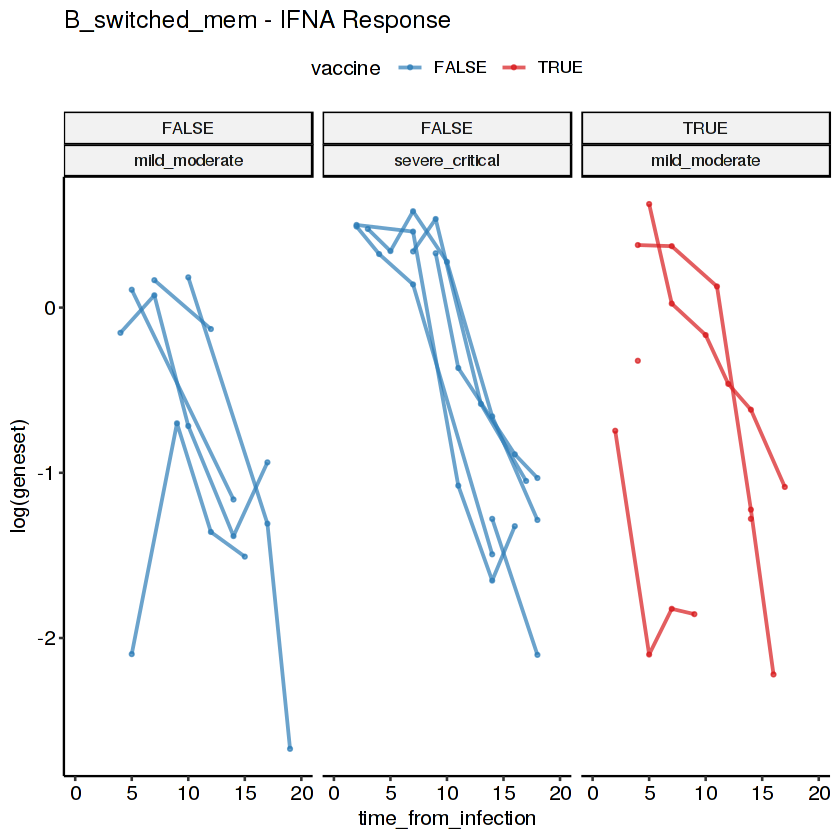

Saving 6.67 x 6.67 in image



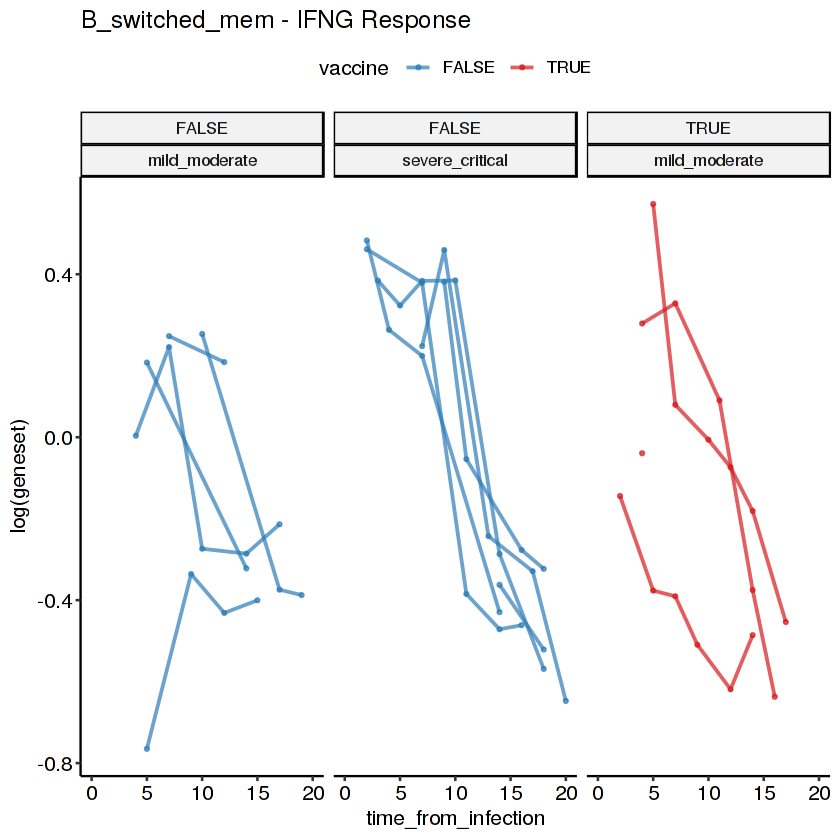

Saving 6.67 x 6.67 in image



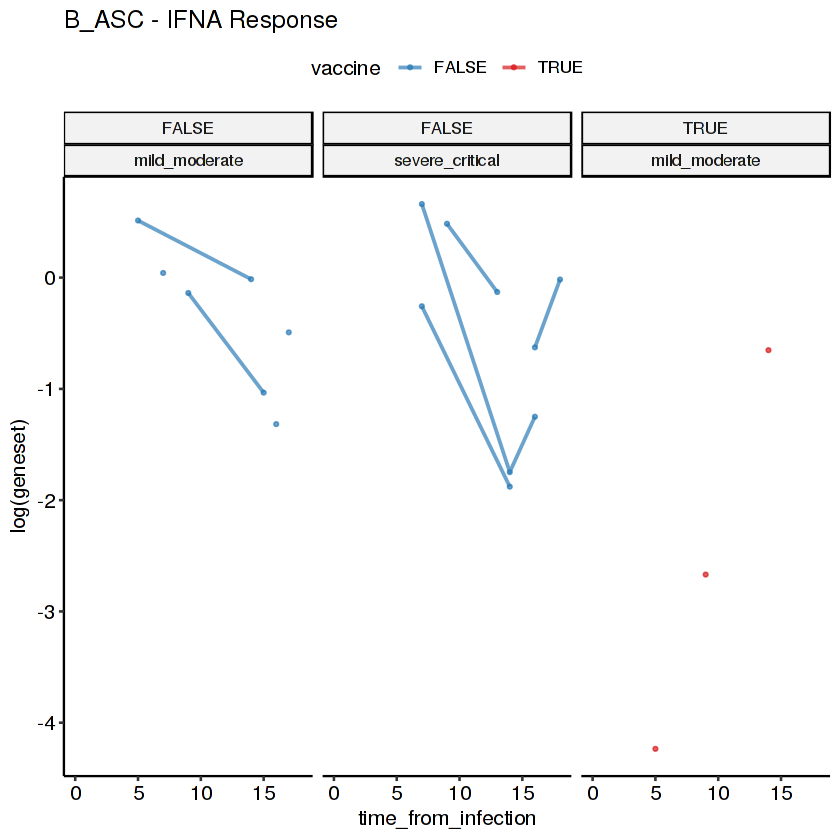

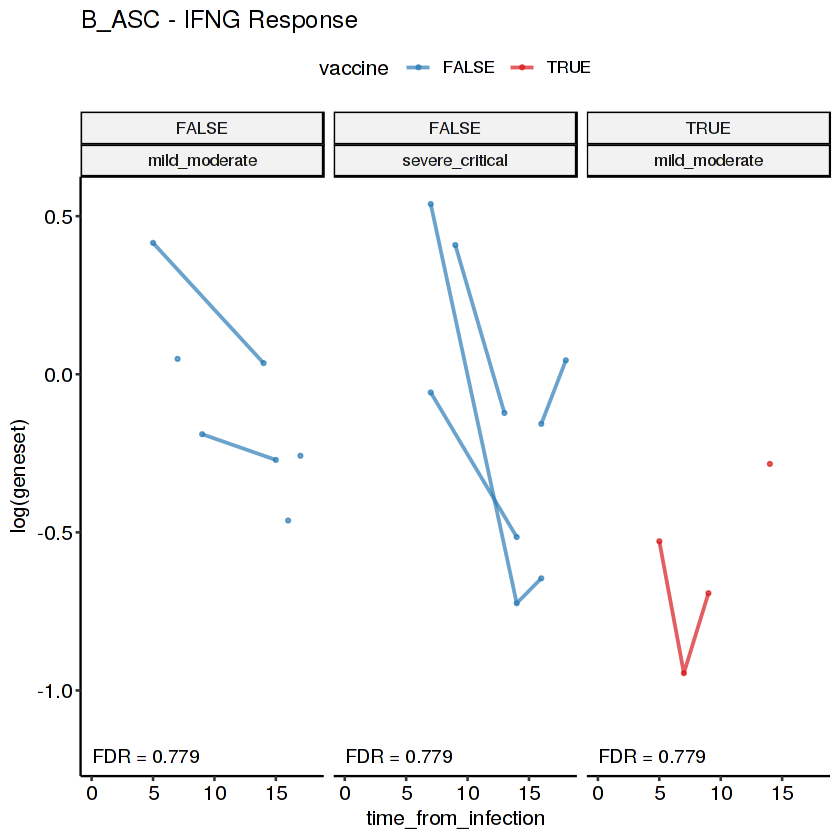

In [51]:
for (i in seq_along(fits2v)){
    for (j in c(26, 27)){
        x = emmeans(fits2v[[i]][[j]]$fit, ~ time_from_infection | vaccine, at = list(time_from_infection = 0:21))
        if (j == 26){
            jj = 'IFNA Response'
        } else {
            jj = 'IFNG Response'
        }
        main = paste0(names(fits2v)[i], ' - ', jj)
        # p <- ggplot(data.frame(x), 
            # aes(time_from_infection, emmean, group = vaccine, fill = vaccine)) +
            # geom_line(aes(colour = vaccine), size = 1.7) +
            # geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
            # scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
            # scale_fill_manual(values = c("#2C7BB6", "#D7191C")) +
        p <- ggplot(fits2v[[i]][[j]]$data,
            aes(time_from_infection, log(geneset), col = vaccine)) +
            geom_point(alpha = 0.7, size = 0.7) +
            geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
            scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
            facet_wrap(~vaccine + grouped_severity) +
            ggtitle(main) +
            annotate(geom = 'text', label = paste0('FDR = ', signif(df_res2v[[i]][j,2], digits = 3)), x = 0, y = min(log(data.frame(x)$emmean)), hjust = 0, vjust = 1)
            print(p)
        ggsave(paste0('figures/longitudinal_geneset/', main, '_vaccine_interaction.pdf'), plot = p)
    }
}